In [1]:
import sys
sys.path.append("../")

from mir.common.repertoire import Repertoire
from mir.basic.kmers import KmersTable, compare_two_repertoire_kmers
from mir.common.parser import *
from scipy.stats import chi2_contingency
import numpy as np
from time import time

In [2]:
from itertools import islice
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests

from mir.common.repertoire import Repertoire


class KmersTable:
    """
    Class to generate series of subsequnces of length k from Repertoire
    """

    def __init__(self, k: int, repertoire: Repertoire):
        """
        Creating a new KmeresTable object

        :param k: length of subsequnces to be generated
        :param repertoire: Repertoire class object
        """
        self.k = k
        self.repertoire = repertoire
        self.vc_k_mers_list_generator = np.vectorize(self._k_mers_list_generator, otypes=[np.ndarray])
        self.kmer_table = None
        self.count_table = None

    def _over_slice(self, cdr3):
        """
        Generator of kmers
        :param cdr3: cdr3 aa sequence
        """
        iterator = iter(cdr3)
        res = tuple(islice(iterator, self.k))
        if len(res) == self.k:
            yield res
        for elem in iterator:
            res = res[1:] + (elem,)
            yield res

    def _k_mers_list_generator(self, clonotype) -> list:
        """
        Form a list from generator
        :param cdr3: cdr3 aa sequence
        :return: list of kmers for cdr3
        """
        cdr3 = clonotype.cdr3aa
        res = ["".join(elem) for elem in self._over_slice(cdr3)]
        return res

    def generate_kmers_table(self) -> pd.Series:
        """
        Generate the table with kmers for repertoire
        :return: Series of kmers arrays for each cdr3 in repertoire
        """
        if self.kmer_table:
            return self.kmer_table
        else:
            self.kmer_table = self.vc_k_mers_list_generator(self.repertoire.clonotypes)
            return self.kmer_table

    def generate_kmers_count_table(self) -> dict[str:int]:
        """
        Generate the dict with numbers of occurrence of each kmer in repertoire
        :return: dict with amount of each kmer
        """
        if self.count_table:
            return self.count_table
        else:
            kmers_array = self.generate_kmers_table()
            unique_kmers, kmers_counts = np.unique((np.concatenate(kmers_array)), return_counts=True)
            return dict(zip(unique_kmers, kmers_counts))


def compare_two_repertoire_kmers(repertoire_1: Repertoire,
                                 repertoire_2: Repertoire,
                                 k: int,
                                 plot_comparison=None,
                                 p_adj_func=None
                                 ) -> pd.DataFrame:
    """
    Function to compare 2 Repertoires on the kmers level
    :param repertoire_1: first repertoire
    :param repertoire_2: first repertoire
    :param k: length of subsequnces to be compared
    :param plot_comparison:
    None - do not plot comparison
    'line' - plot log2(frequences) of kmers from two sets
    'volcano' - plot Volcanoplot of kmers comparison
    :param p_adj_func: function to adjust p_values array, which returns array of adjusted ps
    :return: pd.DataFrame with fold change of kmer occurrence between to repertoires
    and chi2 test p values for each kmer
    """
    table_1 = pd.DataFrame.from_dict(KmersTable(k, repertoire_1).generate_kmers_count_table(), orient='index')
    table_2 = pd.DataFrame.from_dict(KmersTable(k, repertoire_2).generate_kmers_count_table(), orient='index')

    table_1.columns = ['count_1']
    table_2.columns = ['count_2']

    res = table_1.join(table_2, how='outer').fillna(0)
    res['p_val'] = np.nan
    n = res.count_1.sum()
    m = res.count_2.sum()
    res['freq_1'] = res.count_1/n
    res['freq_2'] = res.count_2/m    

    for kmer in res.index:
        res.loc[kmer, 'p_val'] = chi2_contingency([[res['count_1'][kmer], n - res['count_1'][kmer]],
                                         [res['count_2'][kmer], m - res['count_2'][kmer]]])[1]

    res['freq_fc'] = (res.count_1/n)/(res.count_2/m)


    if not p_adj_func:
        res['p_val_adj'] = multipletests(res.p_val, method='holm')[1]
    else:
        res['p_val_adj'] = p_adj_func(res.p_val)


    if plot_comparison == 'volcano':

        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        plt.scatter(np.log2(res.freq_fc), -np.log2(res.p_val.apply(lambda x: 2 ** (-100) if x < 2 ** (-100) else x)),
                    s=1)
        plt.xlabel('logFC')
        plt.ylabel('-log(p)')

        top_results = res[res.freq_fc.apply(lambda x: not np.isinf(np.log2(x)))].sort_values(by='p_val').head(10)
        top_results.p_val = top_results.p_val.apply(lambda x: 2 ** (-100) if x < 2 ** (-100) else x)
        for index, row in top_results.iterrows():
            x = np.log2(row['freq_fc'])
            y = -np.log2(row['p_val'])
            plt.annotate(index, (x, y), textcoords="offset points", ha='center',
                         xytext=(0, 10), arrowprops=dict(arrowstyle='-', lw=0.5))

    elif plot_comparison == 'line':

        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 10))
        plt.scatter(np.log2(freq_1), np.log2(freq_2), s=1)
        plt.plot([np.log2(freq_1.min()), np.log2(freq_1.max())],
                 [np.log2(freq_1.min()), np.log2(freq_1.max())], '--', c='red')
        plt.xlabel('log2(freq_1)')
        plt.ylabel('log2(freq_2)')

    return res

In [2]:
lib = SegmentLibrary.load_default()
lib.complete = False
parser = VDJtoolsParser(lib)
rep = Repertoire.load(parser, path='assets/samples/aging_3year/A5-S23.txt.gz')
rep_1 = Repertoire.load(parser, path='assets/samples/aging_3year/A6-I201ob.txt.gz')
print([(c.cells, c.cdr3aa) for c in rep[0:5]])
print(rep)

[(33675, 'CASRSTGFYNEQFF'), (33660, 'CASSRTGNEQYF'), (27294, 'CAISESLGEQFF'), (18291, 'CASSFEQGNSWTQYF'), (16343, 'CASSLGADTQYF')]
Repertoire of 137624 clonotypes and 517858 cells:
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CASRSTGFYNEQFF TGTGCCAGCAGATCAACAGGGTTCTACAATGAGCAGTTCTTC
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CASSRTGNEQYF TGTGCCAGCAGCAGGACAGGGAACGAGCAGTACTTC
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CAISESLGEQFF TGTGCCATCAGTGAGTCGCTTGGTGAGCAGTTCTTC
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'],
      dtype='object') CASSFEQGNSWTQYF TGTGCCAGCAGTTTCGAGCAGGGAAATTCGTGGACCCAGTACTTC
κIndex(['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'J

In [3]:
st = time()

kmers = KmersTable(k = 3, repertoire = rep)
res_dict = kmers.generate_kmers_count_table()

kmers_1 = KmersTable(k = 3, repertoire = rep_1)
res_dict_1 = kmers.generate_kmers_count_table()

fin = time()
print(fin - st)

1.6742632389068604


In [4]:
pd.DataFrame.from_dict(res_dict, orient='index')

,0
***,1
**A,1
**D,1
**E,7
**F,1
...,...
_YS,17
_YT,6
_YV,2
_YW,1


In [5]:
kmers = KmersTable(k = 3, repertoire = rep)

kmers.generate_kmers_table()

array([list(['CAS', 'ASR', 'SRS', 'RST', 'STG', 'TGF', 'GFY', 'FYN', 'YNE', 'NEQ', 'EQF', 'QFF']),
       list(['CAS', 'ASS', 'SSR', 'SRT', 'RTG', 'TGN', 'GNE', 'NEQ', 'EQY', 'QYF']),
       list(['CAI', 'AIS', 'ISE', 'SES', 'ESL', 'SLG', 'LGE', 'GEQ', 'EQF', 'QFF']),
       ..., list(['CAS', 'ASG', 'SGY', 'GYL']),
       list(['CAS', 'AS_', 'S_Y', '_YF']),
       list(['CAS', 'AS_', 'S_F', '_FF'])], dtype=object)

/home/dluppov/.conda/envs/mir11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,count_1,count_2,p_val,freq_1,freq_2,freq_fc,p_val_adj
***,1.0,2.0,0.949003,5.861455e-07,2.123493e-07,2.760289,1.0
**A,1.0,1.0,0.704478,5.861455e-07,1.061747e-07,5.520579,1.0
**C,0.0,1.0,1.000000,0.000000e+00,1.061747e-07,0.000000,1.0
**D,1.0,1.0,0.704478,5.861455e-07,1.061747e-07,5.520579,1.0
**E,7.0,7.0,0.001244,4.103019e-06,7.432226e-07,5.520579,1.0
...,...,...,...,...,...,...,...
_YS,17.0,68.0,0.297034,9.964474e-06,7.219876e-06,1.380145,1.0
_YT,6.0,39.0,0.868166,3.516873e-06,4.140811e-06,0.849320,1.0
_YV,2.0,5.0,0.654629,1.172291e-06,5.308733e-07,2.208231,1.0
_YW,1.0,0.0,0.336053,5.861455e-07,0.000000e+00,inf,1.0


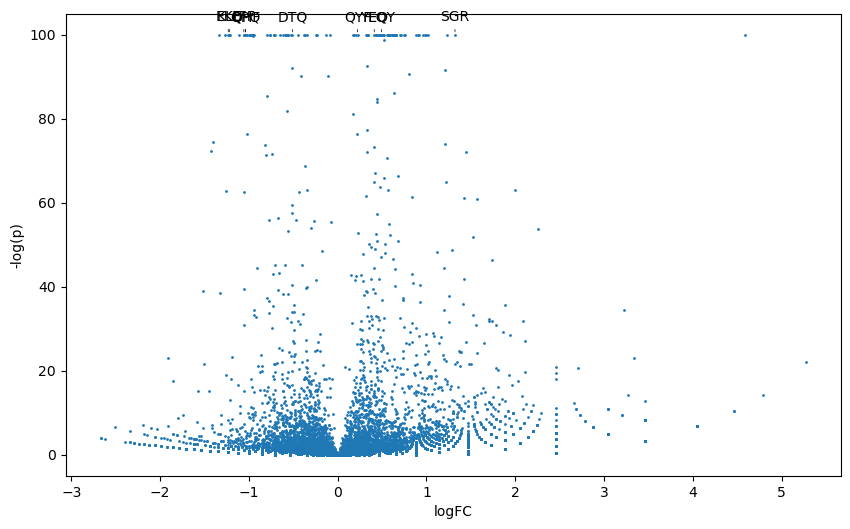

In [6]:
res = compare_two_repertoire_kmers(rep, rep_1, k=3, plot_comparison = 'volcano')
res

In [ ]:
kmers.compare_with_another_KmersTable(kmers_1, plot_comparison='line')

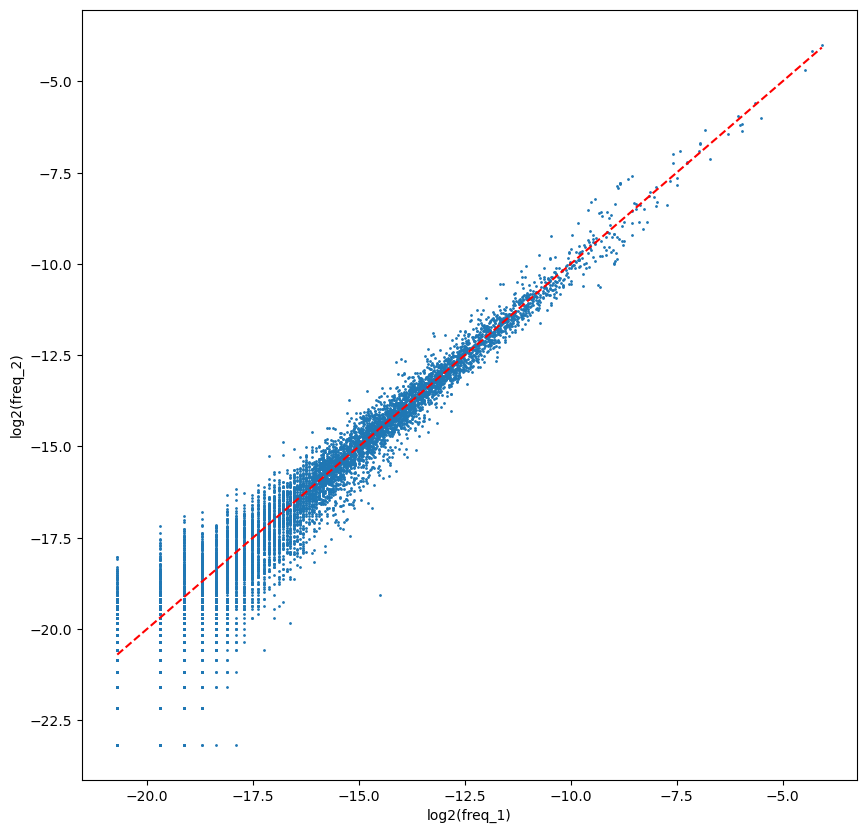

In [6]:
res = compare_two_repertoire_kmers(rep, rep_1, 3, plot_comparison = 'line')

In [7]:
res

,freq_fc,p_val,p_val_adj
KDI,2.006845,0.024107,1.0
C_N,5.518824,0.218764,1.0
VHE,1.301382,0.002908,1.0
CET,1.314006,0.780716,1.0
NSF,1.254278,0.522434,1.0
...,...,...,...
QI*,1.379706,1.000000,1.0
WNL,0.643863,0.346326,1.0
IMQ,1.471686,0.709413,1.0
*YG,0.919804,1.000000,1.0
